## Early Intervention and Optimal Lockdown Severity

This intention of this notebook is to explore the notion "the harder the lockdown, the better". My model uses far too many simplifying assumptions to have implications for policy, but is an interesting exercise nonetheless. The [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) provides the foundation for my model here.

More explicitly, the goal of this notebook is to establish how a parsimonious SIR model suggests optimal severity of a lockdown might change with how soon a lockdown takes place following initial infection. I consider optimality to be the situation in which the *fewest people are infected by the virus overall*; since deaths are not modelled explicitly and are included in those who have "recovered", I look to minimise the limiting value of "recoveries".

This was inspired by a preamble from one of my Macroeconomics problem sets, as given below...

---

\[The SIR model\] is very simple and I want you to already start thinking about it and in particular learn from this simple exercise that the dynamics may be somewhat subtle.

- $S_t$, Susceptibles: Fraction of people that have not yet been affected.
- $I_t$, Infectious: Fraction of people that currently are infected and contagious.
- $R_t$, “Recovered”: Fraction of people that was infected but is no longer contagious. This fraction of people who have died and those who have truly recovered.

We will only consider health consequences and ignore discounting. This means that the damage of the pandemic is the limiting value of $R_t$.

**Model Equations**

$$
\begin{aligned}
S_t - S_{t-1} &= -\beta S_{t-1} I_{t-1} \\
I_t - I_{t-1} &= \beta S_{t-1}I_{t-1} - \gamma I_{t-1} \\
R_t - R_{t-1} &= \gamma I_{t-1}
\end{aligned}
$$

**Definitions and Parameters, Initial Values**

- $\mathbb{R} = 2.5$: Basic reproduction number (total number of transmissions of an infectious person)
- $\mathbb{T} = 7$: Duration of being infected
- $\beta = \mathbb{R}/\mathbb{T}$: Transmission rate (per period)
- $\gamma = 1/\mathbb{T}$: Exit rate (recovery or death)
- $I_1 = 0.001$
- $S_1 = 0.999$
- $R_1$ = 1

The equations are quite intuitive. Each period, a fraction $\gamma$ of infected people is no longer contageous (either recovers or dies). The decrease in the number of healthy people depends on the product of the number of infected people and the stock of healthy people. Note that $S_t +I_t +R_t = 1$.

---

The premise of the exercise was that we were to compare the efficacy of two 25-day lockdowns starting on day 31, one where the infection rate $\beta$ is reduced by half for the duration (partial lockdown), and another where $\beta = 0$ for the duration (full lockdown). I ignore this specific exercise here.

### Assumption Tweaks

#### Feasibility of a Full Lockdown

I assume that eliminating transmission completely is unfeasible, and only study cases where lockdown can reduce transmission by up to 99%.

#### Feasibility of Elimination

Since we use a unit measure of people in the above model, the infection rate may *tend* to zero, but will never reach it; the virus is never truly eliminated. This ignores a clear integer constraint - there is a countable number of people on earth.

I consider a country with 100 million people, and as such if for some $t$ we have...

$$
I_t \leq 0.5 \cdot 10^{-8}
$$

...I overide the model and let $I_t = 0$, such that the virus has been eliminated.

#### Recovery

In the model as given, $1/\mathbb{T} = 1/7$ infected people will "recover" (get better or die) each period.

In this case, it does hold that the mean length of infection for each person is 7 days. However, if 100,000 people are infected in period 0, then 1,335 of those will still be infected in period 28, and 18 will still be infected in period 56.

This seems untenably unrealistic. Instead, I assume that for each person infected, the duration of their infection is distributed according to...

$$
Duration - 1 \sim \text{Poisson}(6)
$$

This preserves our mean duration length of 7 (and indeed our calculation of $\beta$, for which the mean length of duration is the only relevant moment). However, if the same 100,000 people are infected in period 0, only 0.0000063 people will be infected in period 28.

Thus, we re-write our model equations...

**Altered Model Equations**

Let the number of people *newly* infected in period $t$ be given by $I_t^{new}$, with...

$$
I^{new}_t = \begin{cases} \begin{aligned} &0.001&&\text{if}~t=1 \\ &\beta S_{t-1} I_{t-1}&&\text{if}~t>1 \end{aligned} \end{cases}
$$

Letting...

$$
X \sim \text{Poisson}(6)
$$

The altered model equations are given by...

$$
\begin{aligned}
S_t - S_{t-1} &= -\beta S_{t-1} I_{t-1} \\
I_t - I_{t-1} &= \beta S_{t-1}I_{t-1} - \sum_{j=1}^{t-1} \mathbb{P}(X = j - 1) \cdot I^{new}_j \\
R_t - R_{t-1} &= \sum_{j=1}^{t-1} \mathbb{P}(X = j - 1) \cdot I^{new}_j
\end{aligned}
$$

Parameters and initial values are left unchanged.

###  1 - The SIR Model In Action

Throughout, there is assumed to be a **single, 25-period lockdown**. The start date of the lockdown and the severity (i.e. the percentage reduction in the transmission rate) are allowed to vary.

#### 1.1 - Strict Lockdown

We first run the model with a lockdown **starting in period 25** with a **severity of 0.8**, i.e. an 80% reduction in transmission rate for the duration of the lockdown...

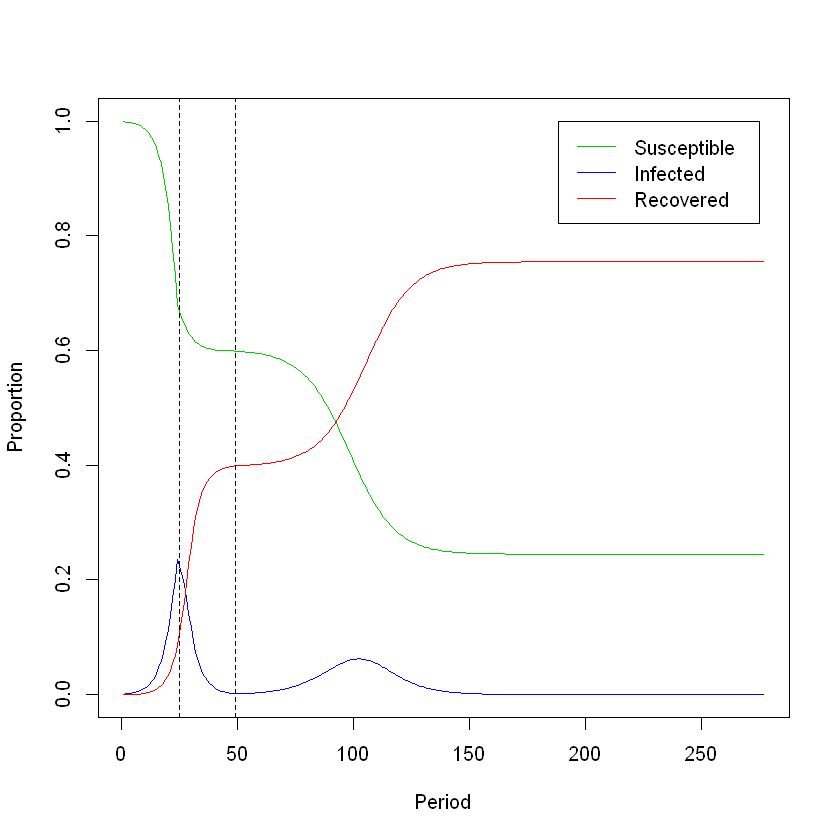

In [34]:
r <- 2.5 #     The reproduction rate - the average number of people each infected person infects in turn when *everybody* is 
         #     susceptible

d <- 7 #     Mean length of infection

beta <- r/d #     daily reproduction coefficient

l_length <- 25 #     lockdown length

l_start <- 25 #     lockdown start period

l_end <- l_start + l_length #     first period after lockdown

sev <- 0.8 #     severity of lockdown

R <- c(0) #     Initiates vector of proportion "recovered"

I <- c(0.001) #     Initiates vector of proportion infected

New_I <- I #     Initiates vector tracking new infections each period

S <- c(1 - I[1]) #     Initiates vector of susceptible population

for(i in 2:10000){ #     Starts period loop - In all cases, virus is eliminated before 10,000 days
  
  if(i == l_start){ #     checks for start of lockdown, switches beta values
    
    beta_old <- beta
    
    beta <- beta_old*(1 - sev)
    
  }
  
  if(i == l_end){ #     checks for end of lockdown, switches beta values back
    
    beta <- beta_old
    
  }
  
  lag <- i - 1 #     lag period
  
  exits <- 0 #     counter for proportion of people moving from infected to recovered this period
  
  for(j in 1:(i-1)){ #     loops through each past period, giving number of recoveries according to the specified distribution 
    
    target <- i - j #     i.e. target period
    
    exits <- exits + dpois(j - 1, lambda = d - 1)*New_I[target]
    
  }
  
  New_I_t <- beta*S[lag]*I[lag] #     Number of new infections this period
  
  New_I <- c(New_I, New_I_t)
  
  S_t <- S[lag] - New_I_t #     Number susceptible this period
  
  S <- c(S,S_t)
  
  I_t <- I[lag] + New_I_t - exits #     Number infected this period
  
  R_t <- exits + R[lag] #     Number "recovered" as of this period
  
  R <- c(R,R_t)
  
  if(I_t <= 0.5*10**(-8)){ #     Structure that checks for virus elimination as specified in "Assumption Tweaks"
    
    I <- c(I,0)
      
    break #     Breaks loop since virus has been eliminated
  
  } else { 
    
    I <- c(I,I_t)
  
  }
  
}

## PLOTTING 

df <- as.data.frame(cbind(S,I,R), colnames = c("S","I","R"))

matplot(df, lty = 1, type = "l", xlab = "Period", 
        ylab = "Proportion", ylim = c(0,1), col = c(3,4,2))

abline(v = l_start, lty = 2)
abline(v = l_end - 1, lty = 2)

legend(x = length(S)*0.68, y = 1,
       legend = c("Susceptible", "Infected", "Recovered"),
       col = c(3,4,2), lty = 1)

Above we see that, whilst the lockdown substantially reduces the number of infections, a second wave (peaking just after period 100) almost doubles the number affected by the virus overall. The limiting proportion of people affected here is **75.5%**.

#### 1.2 - Moderate Lockdown

We again run the model with a lockdown **starting in period 25**, but switch to a lesser **severity of 0.5**, i.e. an 50% reduction in transmission rate for the duration of the lockdown...

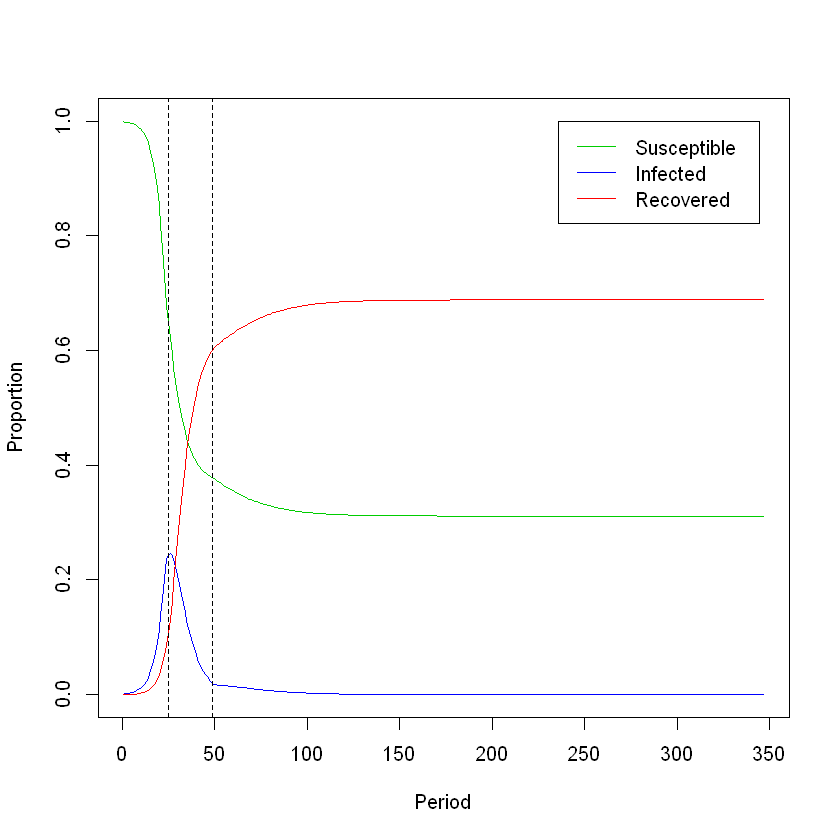

In [35]:
r <- 2.5

d <- 7

beta <- r/d

l_length <- 25

l_start <- 25

l_end <- l_start + l_length

sev <- 0.5 #     The severity is reduced here

R <- c(0)

I <- c(0.001)

New_I <- I

S <- c(1 - I[1])

for(i in 2:10000){
  
  if(i == l_start){
    
    beta_old <- beta
    
    beta <- beta_old*(1 - sev)
    
  }
  
  if(i == l_end){
    
    beta <- beta_old
    
  }
  
  lag <- i - 1
  
  exits <- 0
  
  for(j in 1:(i-1)){
    
    target <- i - j
    
    exits <- exits + dpois(j - 1, lambda = d - 1)*New_I[target]
    
  }
  
  New_I_t <- beta*S[lag]*I[lag]
  
  New_I <- c(New_I, New_I_t)
  
  S_t <- S[lag] - New_I_t
  
  S <- c(S,S_t)
  
  I_t <- I[lag] + New_I_t - exits
  
  R_t <- exits + R[lag]
  
  R <- c(R,R_t)
  
  if(I_t <= 0.5*10**(-8)){
    
    I <- c(I,0)
      
    break
  
  } else { 
    
    I <- c(I,I_t)
  
  }
  
}

# PLOTTING

df <- as.data.frame(cbind(S,I,R), colnames = c("S","I","R"))

matplot(df, lty = 1, type = "l", xlab = "Period", 
        ylab = "Proportion", ylim = c(0,1), col = c(3,4,2))

abline(v = l_start, lty = 2)
abline(v = l_end - 1, lty = 2)

legend(x = length(S)*0.68, y = 1,
       legend = c("Susceptible", "Infected", "Recovered"),
       col = c(3,4,2), lty = 1)

With the *less strict* lockdown, the limiting proportion of people affected is *lower*, at **68.9%**.

For intuition, note that the rate at which people are infected is a function not only of the proportion infected but also the proportion susceptible. At the end of this lockdown, a greater number is infected, but a lesser number are susceptible. This prevents the second-wave that we saw with the stricter lockdown. 

### 2 - Performance of Different Severities for Given Lockdown Dates

Here, I loop through lockdown severities from 0 (no lockdown) to 0.99 (99% reduction in infection rate) in incremenets of 0.01. I then plot the limiting proportion affected against severities. We continue to assume a 25 day lockdown **starting in period 25**.

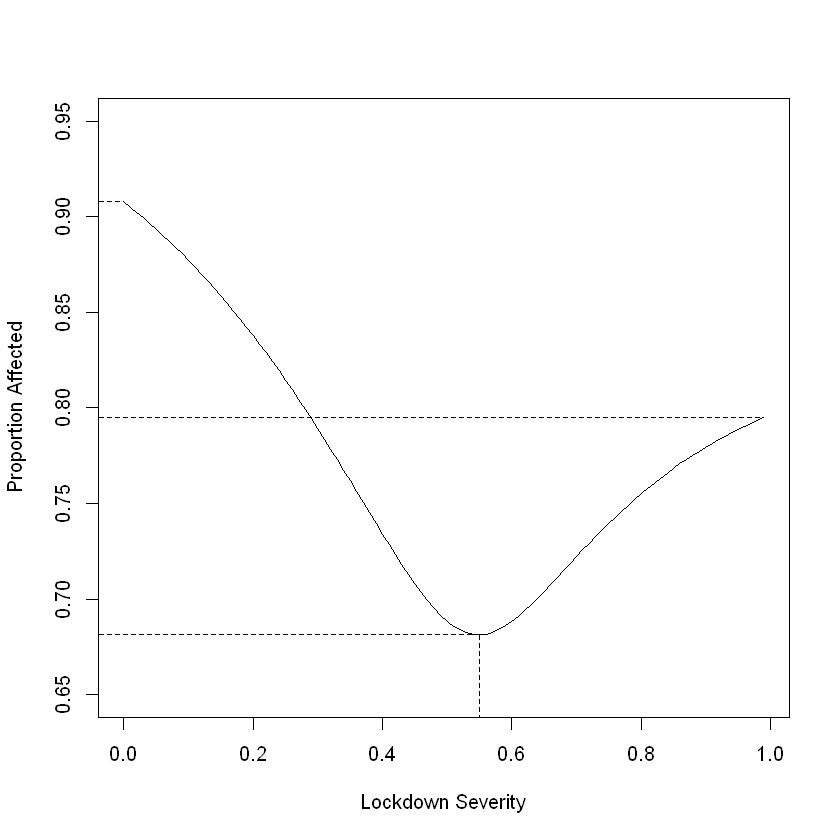

In [36]:
r <- 2.5

t <- 7

beta <- r/t

l_length <- 25

l_start <- 25

l_end <- l_start + l_length

affected <- c() #     Initiates the vector of limiting proportions affected for each severity

for(s in seq(from = 0, to = 0.99, by = 0.01)){ #     Loops through severities
  
  R <- c(0)
  
  I <- c(0.001)
  
  New_I <- I
  
  S <- c(1 - I[1])
  
  for(i in 2:10000){ #     Initiates simulation for this severity
    
    if(i == l_start){
      
      beta_old <- beta
      
      beta <- beta_old*(1 - s)
      
    }
    
    if(i == l_end){
      
      beta <- beta_old
      
    }
    
    lag <- i - 1
    
    exits <- 0
    
    for(j in 1:(i-1)){
      
      target <- i - j
      
      exits <- exits + dpois(j - 1, lambda = t - 1)*New_I[target]
      
    }
    
    New_I_t <- beta*S[lag]*I[lag]
    
    New_I <- c(New_I, New_I_t)
    
    S_t <- S[lag] - New_I_t
    
    S <- c(S,S_t)
    
    I_t <- I[lag] + New_I_t - exits
    
    R_t <- exits + R[lag]
    
    R <- c(R,R_t)
    
    if(I_t <= 0.5*10**(-8)){
      
      I <- c(I,0)
        
      break
      
    } else { 
      
      I <- c(I,I_t)
      
    }
    
  }
  
  affected <- c(affected, R[length(R)]) #     Updates vector of proportion affected with that of this severity
  
}

# PLOTTING

plot(seq(from = 0, to = 0.99, by = 0.01),affected, type = "l",
     xlab = "Lockdown Severity", ylab = "Proportion Affected",
     ylim = c(0.65,0.95))

lines(c(-0.1,0),c(affected[1],affected[1]), lty = 2)
lines(c(-0.1,0.99),c(affected[100],affected[100]), lty = 2)
lines(c(-0.1,(which.min(affected) - 1)/100),c(min(affected),min(affected)), lty = 2)
lines(c(((which.min(affected) - 1)/100),((which.min(affected) - 1)/100)),c(0,min(affected)), lty = 2)

Here we see that the number of people affected overall is not necessarily monotonic in lockdown severity. 

This is the result of countervailing forces. At the end of the lockdown, the temporary decrease in the reproduction rate will have both reduced the number of people infected and increased the number of people susceptible relative to no lockdown.

If the lockdown is too lax, too many people are infected or recovered by the time it is finished. If it is too strict, too many people are susceptible by the time it finishes, and a second wave will occur. The key is balancing the number of people infected during lockdown and infected after lockdown.

### 3 - Lockdown Timing and Optimal Severity

#### 3.1 - The Plot

Below, I allow both the start date of the lockdown and the severity to vary, and plot optimal severity against the starting period of the lockdown. Below this, I plot the limiting proportion of people affected by an optimally severe lockdown against the starting period of the lockdown. 

*Note: This code took about five minutes to run on my laptop*.

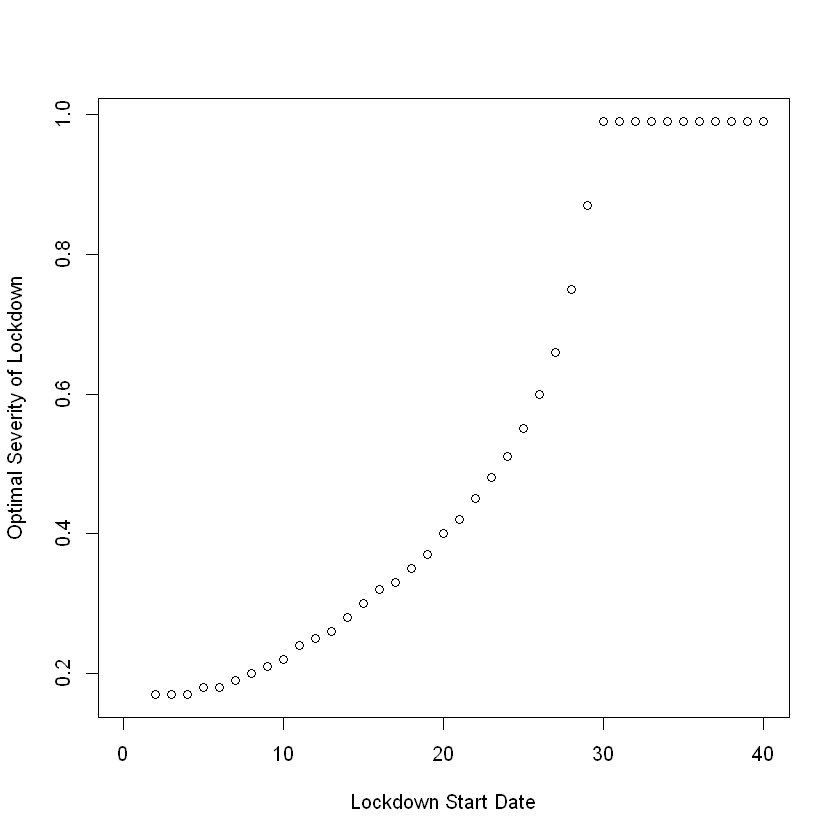

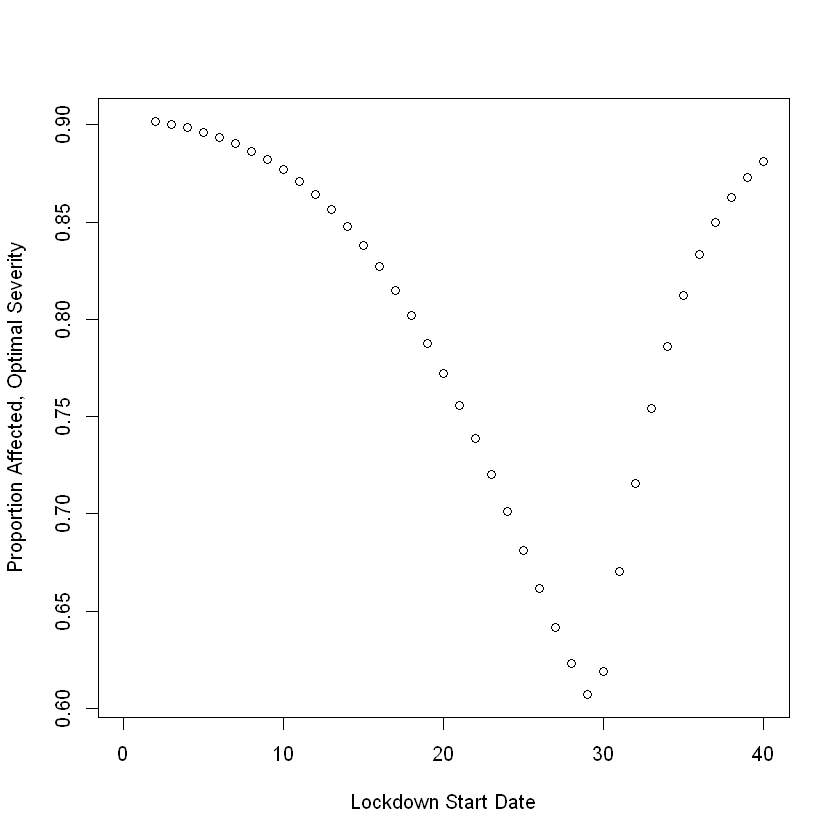

In [38]:
r <- 2.5

t <- 7

beta <- r/t

l_length <- 25

opt_severities <- c() #     Initiates the vector containing the optimal severity for each start date.

opt_affected <- c() #     Initiates the vector containing the number of people affected in the optimal lockdown for a given
                    #     start date.

for(intervention_date in 2:40){
  
  l_start <- intervention_date
  
  l_end <- l_start + l_length
  
  affected <- c()
  
  for(s in seq(from = 0, to = 0.99, by = 0.01)){
    
    R <- c(0)
    
    I <- c(0.001)
    
    New_I <- I
    
    S <- c(1 - I[1])
    
    New_I_t <- 0.001
    
    for(i in 2:1000){
      
      if(i == l_start){
        
        beta_old <- beta
        
        beta <- beta_old*(1 - s)
        
      }
      
      if(i == l_end){
        
        beta <- beta_old
        
      }
      
      lag <- i - 1
      
      exits <- 0
      
      for(j in 1:(i-1)){
        
        target <- i - j
        
        exits <- exits + dpois(j - 1, lambda = t - 1)*New_I[target]
        
      }
      
      New_I_t <- beta*S[lag]*I[lag]
      
      New_I <- c(New_I, New_I_t)
      
      S_t <- S[lag] - New_I_t
      
      S <- c(S,S_t)
      
      I_t <- I[lag] + New_I_t - exits
      
      R_t <- exits + R[lag]
      
      R <- c(R,R_t)
      
      if(I_t <= 0.5*10**(-8)){
        
        I <- c(I,0)
        
        break
        
      } else { 
        
        I <- c(I,I_t)
        
      }
      
    }
    
    affected <- c(affected, R[length(R)])
    
  }
  
  opt_severity <- (which.min(affected) - 1)/100 #     Calculates optimal severity from the index of the minimal value in the
                                                #     vector containing the limiting proportions of people affected
  
  opt_severities <- c(opt_severities, opt_severity)
  
  opt_affected <- c(opt_affected, min(affected)) #     Updates the optimal proportion affected vector
  
}

# PLOTTING

plot(2:40, opt_severities, xlab = "Lockdown Start Date",
     ylab = "Optimal Severity of Lockdown", xlim = c(0,40))

plot(2:40, opt_affected, xlab = "Lockdown Start Date",
     ylab = "Proportion Affected, Optimal Severity", 
     xlim = c(0,40))


Here we see that, the earlier the lockdown, the less severe that lockdown need be in order to minimise total number affected. However, in order to minimise the total number affected overall with a 25 period lockdown, we have an optimal strategy of a lockdown **starting in period 29** with **severity 0.87**. Personally, I'm surprised that the optimal severity is not 0.99 at the earliest possible date for which 0.99 is optimal, but perhaps this would be the case if my analysis were performed in continuous time, with the lockdown starting somewhere between 29 and 30.

### Conclusions?

This model abstracts from many important factors which characterise the ongoing Coronavirus pandemic...

- I assume that minimising overall infections and minimising deaths are equivalent. Thus, I assume that death rate is constant, and therefore deaths are exactly proportional to the number of people infected overall. More sensibly, one might model the death rate as a function of the number of people infected (think overwhelmed hospitals).
- The choice of reproduction rate (2.5) and mean duration of infection (7 periods) are somewhat arbitrary, and are not calibrated to Covid-19 data.
- All previously infected people are assumed be unable to contract the virus again (this includes, unsurprisingly, those who are dead).
- There are no spatial considerations. This means an infected person is equally likely to infect any member of the susceptible population, regardless of proximity.
- There is no population heterogeneity; expected duration of infection and death rate are constant across the population.
- The model does not allow for varying lockdown length, or for a policy of "rolling lockdowns", or for the possibility of vaccination.

Nonetheless, my simulations refute the notion that a harder lockdown is *necessarily* a better lockdown. Indeed, it suggests that acting "hard and fast" may be counterproductive, and that early intervention isn't always necessarily best. That being said, it is unclear whether the results on the sub-optimality of early intervention will generalise when lockdown length is allowed to vary. Finding that out would take my laptop much longer than I care to wait.